# Set modules, parameters, constants

Import modules:

In [1]:
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

import tensorflow as tf

Constants:

In [2]:
# Constants
MAX_TOKENS = 398 # mNG: 396 + 2 (Including 5' start, 3' end)
OUT_TOKENS = 146
BUFFER_SIZE = 5000
BATCH_SIZE = 128
VOCAB_SIZE = 8

# Hyperparameters
num_layers = 2
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.1
epochs = 30

# Train, validation, test fractions
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

# Prepare data set

In [3]:
# Import dataset .csv file
with open('rna_dataset_processed_v4.json', 'r') as f:
    rna_dataset_json = f.read()

# Convert JSON string to DataFrame
rna_dataset_df = pd.read_json(rna_dataset_json, orient='records', lines=True)

### Using a single nucleotide: A,U,C,G,I

Tokenize nucleotides:

In [4]:
# Define a function to tokenize a RNA sequence (string of sequences, 5-to-3)
def tokenize_rna(rna_sequence):
  # Define a dictionary mapping nucleotides to indices
  nucleotide_to_index = {'': 0, '5': 1, '3': 2, 'A': 3, 'T': 4, 'C': 5, 'G': 6, 'I': 7}

  # Create an empty token array
  rna_token = np.zeros(len(rna_sequence),dtype=int)

  # Fill array with corresponding nucleotide tokens:
  for i, nucleotide in enumerate(rna_sequence):
      rna_token[i] += nucleotide_to_index[nucleotide]

  return rna_token

De-tokenize nucleotides (to interpret output):

In [5]:
# Define a function to de-tokenize a RNA sequence, from tokens to a string
def detokenize_rna(rna_token):
    # Define a dictionary mapping indices to nucleotides
    index_to_nucleotide = {0: '', 1: '5', 2: '3', 3: 'A', 4: 'T', 5: 'C', 6: 'G', 7: 'I'}

    # Create an empty string
    sequence = ''

    # Fill array with corresponding nucleotides:
    for i, token in enumerate(rna_token):
        sequence += index_to_nucleotide[int(token)]

    return sequence

In [6]:
# Tokenize sequences
rna_dataset_df['in_rna_token'] = rna_dataset_df['in_rna_seq'].apply(tokenize_rna)
rna_dataset_df['out_rna_token'] = rna_dataset_df['out_rna_seq'].apply(tokenize_rna)

Trim / add padding up to MAX_TOKENS:

In [7]:
# Add padding to fill up to MAX_TOKENS
# Define a function to add padding
def trim_padding(rna_token):    
    row_len = len(rna_token)
    
    if row_len < MAX_TOKENS:
        padding = np.zeros((MAX_TOKENS - row_len))
        rna_token = np.concatenate((rna_token, padding))
        return rna_token
    elif row_len > MAX_TOKENS:
        rna_token[:MAX_TOKENS-1]
        return rna_token
    else:
        return rna_token

In [8]:
# Trim / add padding
rna_dataset_df['in_rna_token'] = rna_dataset_df['in_rna_token'].apply(trim_padding)
rna_dataset_df['out_rna_token'] = rna_dataset_df['out_rna_token'].apply(trim_padding)

In [9]:
in_dataset = tf.data.Dataset.from_tensor_slices(
    [tf.convert_to_tensor(arr, dtype=tf.int64) for arr in rna_dataset_df['in_rna_token']])

out_dataset = tf.data.Dataset.from_tensor_slices(
    [tf.convert_to_tensor(arr, dtype=tf.int64) for arr in rna_dataset_df['out_rna_token']])

In [10]:
rna_dataset = tf.data.Dataset.zip((in_dataset, out_dataset))

Divide data set into Train, Validation, Test:

In [11]:
# Data size = 3652
dataset_size = rna_dataset_df.shape[0]
train_size = int(dataset_size * train_frac)
val_size = int(dataset_size * val_frac)
test_size = dataset_size - train_size - val_size

In [12]:
print('Total size:', dataset_size)
print('Train size:', train_size)
print('Validation size:', val_size)
print('Test size:', test_size)

Total size: 3652
Train size: 2921
Validation size: 365
Test size: 366


In [13]:
# Split data
rna_dataset.shuffle(buffer_size=dataset_size)

train_dataset = rna_dataset.take(train_size)
val_dataset = rna_dataset.skip(train_size).take(val_size)
test_dataset = rna_dataset.skip(train_size + val_size).take(test_size)

In [14]:
# Save dataset
train_dataset_path = "training_3/train_dataset"
val_dataset_path = "training_3/val_dataset"
test_dataset_path = "training_3/test_dataset"

train_dataset.save(train_dataset_path)
val_dataset.save(val_dataset_path)
test_dataset.save(test_dataset_path)

In [15]:
# Load dataset
train_dataset = tf.data.Dataset.load(train_dataset_path)
val_dataset = tf.data.Dataset.load(val_dataset_path)
test_dataset = tf.data.Dataset.load(test_dataset_path)

Prepare data into tf.keras.model requirements: (inputs, labels):
where inputs = (input_rna, output_rna[0:len-1]), labels = output_rna[1:len])

In [16]:
def prepare_batch(in_rna, out_rna):
    # Prepare inputs and labels
    in_rna = in_rna[:,:-1]  # Drop the 3' tokens

    out_rna_inputs = out_rna[:,:-1]  # Drop the 3' tokens
    out_rna_labels = out_rna[:,1:]   # Drop the 5' tokens

    return (in_rna, out_rna_inputs), out_rna_labels

In [17]:
def make_batches(ds):
  return (
      ds
      .batch(BATCH_SIZE)
      .map(prepare_batch)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [18]:
train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)

Test model using one sample from train_batches:

In [19]:
for (in_rna, out_rna_inputs), out_rna_labels in train_batches.take(1):
  break

# Transformer model

### Positional embedding

Define positional embedding functions:

In [20]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [21]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=dff, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

Embed inputs:

In [22]:
embed_in_rna = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=d_model)
embed_out_rna = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=d_model)

in_rna_emb = embed_in_rna(in_rna)
out_rna_emb = embed_out_rna(out_rna_inputs)

In [23]:
out_rna_emb._keras_mask

<tf.Tensor: shape=(128, 397), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Layers

Base attention layer:

In [24]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

Cross attention layer:

In [25]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Global self attention layer:

In [26]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Causal self attention layer:

In [27]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Feed forward neural network:

In [28]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

### Encoder

In [29]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [30]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

### Decoder

In [31]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [32]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

### Transformer

In [33]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

# Test model

Instantiate the Transformer model:

In [34]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=VOCAB_SIZE,
    target_vocab_size=VOCAB_SIZE,
    dropout_rate=dropout_rate)

Test:

In [35]:
output = transformer((in_rna, out_rna_inputs))

print(in_rna.shape)
print(out_rna_inputs.shape)
print(output.shape)

(128, 397)
(128, 397)
(128, 397, 8)


In [36]:
transformer.summary()


Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  793088    
                                                                 
 decoder (Decoder)           multiple                  1321216   
                                                                 
 dense_8 (Dense)             multiple                  1032      
                                                                 
Total params: 2115336 (8.07 MB)
Trainable params: 2115336 (8.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Train model

Optimizer:

In [37]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instatiate optimizer: Adam optimizer

In [38]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Set up loss and metrics:

In [39]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

Train the model:

In [40]:
# Save model
checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [41]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [77]:
train_history = transformer.fit(train_batches,
                epochs=epochs,
                validation_data=val_batches,
                callbacks=[cp_callback])

Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 0.5492 - masked_accuracy: 0.7788
Epoch 1: saving model to training_3/cp.ckpt
23/23 [==============================] - 183s 8s/step - loss: 0.5492 - masked_accuracy: 0.7788 - val_loss: 0.8477 - val_masked_accuracy: 0.6439
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.5099 - masked_accuracy: 0.7934
Epoch 2: saving model to training_3/cp.ckpt
23/23 [==============================] - 185s 8s/step - loss: 0.5099 - masked_accuracy: 0.7934 - val_loss: 0.7904 - val_masked_accuracy: 0.6684
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.4785 - masked_accuracy: 0.8073
Epoch 3: saving model to training_3/cp.ckpt
23/23 [==============================] - 186s 8s/step - loss: 0.4785 - masked_accuracy: 0.8073 - val_loss: 0.7620 - val_masked_accuracy: 0.6808
Epoch 4/30
23/23 [==============================] - ETA: 0s - loss: 0.4698 - masked_accuracy: 0.8100
Epoch 4: saving model to trainin

In [78]:
# Export training history
train_hist_df = pd.DataFrame(train_history.history)
train_hist_df.to_csv('training_history_v6.csv')

In [79]:
# Evaluate training history
train_loss = train_hist_df['loss']
train_mask_acc = train_hist_df['masked_accuracy']
val_loss = train_hist_df['val_loss']
val_mask_acc = train_hist_df['val_masked_accuracy']

train_perplexity = np.exp(train_loss)
val_perplexity = np.exp(val_loss)

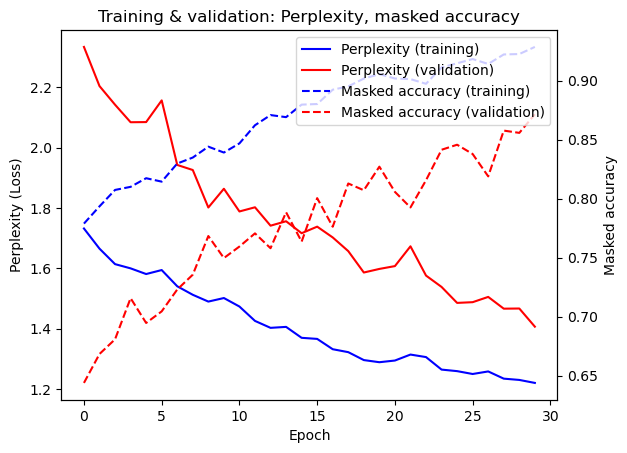

In [80]:
# Plot training history

# Create a figure and axis object
fig, ax1 = plt.subplots()

# Plotting the first two columns on the first y-axis
ax1.plot(train_perplexity, label='Perplexity (training)', color='b', linestyle='-')
ax1.plot(val_perplexity, label='Perplexity (validation)', color='r', linestyle='-')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Perplexity (Loss)')
ax1.tick_params(axis='y')

# Creating a second y-axis
ax2 = ax1.twinx()

# Plotting the other two columns on the second y-axis
ax2.plot(train_mask_acc, label='Masked accuracy (training)', color='b', linestyle='dashed')
ax2.plot(val_mask_acc, label='Masked accuracy (validation)', color='r', linestyle='dashed')

ax2.set_ylabel('Masked accuracy')
ax2.tick_params(axis='y')

# Adding labels and title
plt.title('Training & validation: Perplexity, masked accuracy')

# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

### Run inference

Prepare test dataset

In [81]:
test_sample = test_dataset.batch(1).take(1)

In [82]:
for in_rna_token, out_rna_token in test_sample:
    break

In [83]:
class Translator(tf.Module):
  def __init__(self, transformer):
    self.transformer = transformer

  def __call__(self, sample, out_tokens=OUT_TOKENS):
    # Identify start, end, A, I tokens
    start = tf.convert_to_tensor(tokenize_rna('5'))
    end = tf.convert_to_tensor(tokenize_rna('3'))

    aden_token = tf.convert_to_tensor(tokenize_rna('A'))
    ino_token = tf.convert_to_tensor(tokenize_rna('I'))
    
    aden_pos = int(aden_token[0])
    ino_pos = int(ino_token[0])
    
    for in_rna_token, out_rna_token in sample:
        break
    
    # Encoder input: (1,max_tokens-1)
    encoder_input = in_rna_token[:,1:]
    
    # Decoder template = fixed region (Replace A in place of I)
    out_template_token = tf.where(tf.equal(out_rna_token, 7), 3 * tf.ones_like(out_rna_token), out_rna_token)
    
    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    
    # Begin prediction by providing starting token
    output_array = output_array.write(0, start)
    
    # Autoregressively predict remaining tokens, from left to right
    for i in tf.range(out_tokens-2):
        # Make prediction only for Adenosines
        if out_template_token[:,i+1] == 3:
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
            
            prob_aden = predictions[:,:,aden_pos]
            prob_ino = predictions[:,:,ino_pos]
            
            if prob_ino > prob_aden:
                predicted_id = ino_token[tf.newaxis]
            else:
                predicted_id = aden_token[tf.newaxis]

        # For all else, teacher force prediction to the unedited T,C,G,I
        else:
            predicted_id = tf.transpose(out_template_token[:,i+1])[tf.newaxis]

        # Concatenate the `predicted_id` to the output which is given to the
        # decoder as its input.
        output_array = output_array.write(i+1, predicted_id[0])
    
    # Prediction
    prediction = tf.transpose(output_array.stack())
    prediction_np = prediction.numpy()
    # Output: (1, tokens)
    predict_seq = detokenize_rna(prediction_np[0])
    predict_tokens = prediction_np[0]
    
    # Input sample
    in_rna_token_np = in_rna_token.numpy()
    input_seq = detokenize_rna(in_rna_token_np[0])
    input_tokens = in_rna_token[0]
    
    out_rna_token_np = out_rna_token.numpy()
    ground_truth = detokenize_rna(out_rna_token_np[0])

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return (predict_seq, predict_tokens), (input_seq, input_tokens), ground_truth, attention_weights

In [84]:
# Instatiate translator
translator = Translator(transformer)

In [85]:
(predict_seq, predict_tokens), (input_seq, input_tokens), ground_truth, attention_weights = translator(test_sample)

In [86]:
def print_translation(input_seq, predict_seq, ground_truth):
    print('Input:', input_seq)
    print('Prediction', predict_seq)
    print('Ground truth', ground_truth)

In [87]:
print_translation(input_seq, predict_seq, ground_truth)

Input: 5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCAATGGCGGCTAACTATCTGAAGAACCAGCCGATGTACGTGTTCCGTAAGACGGAGCTCAAGCACTCCAAGACCGAGCTCAACTTCAAGGAGTGGCAAAAGGCCTTTACCGATGTGATGGGCATGGACGAGCTGTACAAGTAATCCCTCACTACCCTCAACCCAAAAACACAACCTTCGAAAGCCACCCGATCCAATGCTTACTTGTTCAGCTCGTCCATGCCCATCACATCGGTAAAGGCCTTTTGCCACTCCTTGAAGTTGAGCTCGGTCTTGGAGTGCTTGAGCTCCGTCTTACGGAACACGTACATCGGCTGGTTCTTCAGATAGTTAGCCGCCATTGGCTGGCGCGCC3
Prediction 5AGCCAATGGCGGCTAACTATCTGAAAACCICCGATGTACGTGTTCCGTAAGACGGAGCTCAAGCACTCIAGACIAGCTCAACTTCAAIAGTGGCAAAAGGITTTACCGATGTGATGGGCATIACGAGCTGTACIIAA3
Ground truth 5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTCCGTAAGACGGAGCTCAAGCACTCIAGACIAGCTCAACTTCAAIAGTGGCAAAAGGITTTACCGATGTGATGGGCATIACGAGCTGTACIIAA3


### Evaluation metrics

In [88]:
def eval_metrics(predict_seq, ground_truth):
    pred_pos = 0
    pred_neg = 0
    label_pos = 0
    label_neg = 0
    
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    
    general_error = 0
    total_pred = 0
    
    predict_len = len(predict_seq)
    truth_len = len(ground_truth)
    max_len = max(predict_len, truth_len)
    
    # Iterate through prediction, and compare with truth
    for i in range(max_len):
        if (predict_seq[i] == 'A') or (predict_seq[i] == 'I') or (ground_truth[i] == 'A') or (ground_truth[i] == 'I'):
            if ground_truth[i] == 'I':
                label_pos += 1
                if predict_seq[i] == 'I':
                    pred_pos += 1
                    true_pos += 1
                elif predict_seq[i] == 'A':
                    pred_neg += 1
                    false_neg += 1
            elif ground_truth[i] == 'A':
                label_neg += 1
                if predict_seq[i] == 'I':
                    pred_pos += 1
                    false_pos += 1
                elif predict_seq[i] == 'A':
                    pred_neg += 1
                    true_neg += 1
            else:
                general_error += 1
            
            total_pred += 1
        else:
            continue
    
    # Calculate evalutaion metrics
    accuracy = (true_pos + true_neg) / total_pred
    precision = true_pos / pred_pos
    pos_recall = true_pos / label_pos
    neg_recall = true_neg / label_neg
    
    return (accuracy, precision, pos_recall, neg_recall)

In [89]:
(accuracy, precision, pos_recall, neg_recall) = eval_metrics(predict_seq, ground_truth)

In [90]:
print('Accuracy:', accuracy * 100, '%')
print('Precision:', precision * 100, '%')
print('Positive recall:', pos_recall * 100, '%')
print('Negative recall:', neg_recall * 100, '%')

Accuracy: 97.91666666666666 %
Precision: 100.0 %
Positive recall: 88.88888888888889 %
Negative recall: 100.0 %


### Run test data

In [91]:
# Store all test results
input_seq_list = [input_seq]
predict_seq_list = [predict_seq]
ground_truth_list = [ground_truth]
accuracy_list = [accuracy]
precision_list = [precision]
pos_recall_list = [pos_recall]
neg_recall_list = [neg_recall]

In [ ]:
for test_i in range(test_size-1):
    # Take on sample each
    test_sample = test_dataset.batch(1).skip(test_i+1).take(1)
    
    # Run prediction
    (predict_seq, predict_tokens), (input_seq, input_tokens), ground_truth, attention_weights = translator(test_sample)
    
    # Calculate accuracy
    (accuracy, precision, pos_recall, neg_recall) = eval_metrics(predict_seq, ground_truth)
    
    # Add 
    input_seq_list.append(input_seq)
    predict_seq_list.append(predict_seq)
    ground_truth_list.append(ground_truth)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    pos_recall_list.append(pos_recall)
    neg_recall_list.append(neg_recall)
    
    # Export output into dataframe, csv file
    # Create a dictionary from the lists
    test_results_dic = {'input_seq': input_seq_list, 'true_edited_seq': ground_truth_list,
                        'predict_seq': predict_seq_list, 'accuracy': accuracy_list, 'precision': precision_list,
                       'pos_recall': pos_recall_list, 'neg_recall': neg_recall_list}

    # Create a Pandas DataFrame
    test_results_df = pd.DataFrame(test_results_dic)
    
    # Export the DataFrame to a CSV file
    test_results_df.to_csv('test_results_v6.csv')

                                           input_seq  \
0  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                     true_edited_seq  \
0  5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1  5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   

                                         predict_seq  accuracy  precision  \
0  5AGCCAATGGCGGCTAACTATCTGAAAACCICCGATGTACGTGTTC...  0.979167        1.0   
1  5AGCCAATGGCGGCTAACTATCTGAAAACCICCGATGTACGTGTTC...  0.977778        1.0   

   pos_recall  neg_recall  
0    0.888889         1.0  
1    0.900000         1.0  
                                           input_seq  \
0  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                     true_edited_seq  \
0  5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1  5AGCCA

                                           input_seq  \
0  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                     true_edited_seq  \
0  5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1  5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2  5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3  5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4  5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
5  5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
6  5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGT

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                      true_edited_seq  \
0   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2   5AGCCAATGGCGGCTAACTATCTGAI

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                              

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
5   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
6   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
7   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
8   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
9   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
10  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
11  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
12  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
13  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
14  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
15  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
16  5ACCTTGGGTCATACGTTAACCGGACA

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                ...   
56  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
57  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
58  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
59  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
60  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                      true_edited_seq  \
0   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4   5AGCCAATGGCGGCTAACTATCTGAI

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                ...   
60  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
61  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
62  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
63  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
64  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                      true_edited_seq  \
0   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4   5AGCCAATGGCGGCTAACTATCTGAI

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                ...   
64  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
65  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
66  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
67  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
68  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                      true_edited_seq  \
0   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4   5AGCCAATGGCGGCTAACTATCTGAI

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                ...   
68  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
69  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
70  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
71  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
72  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                      true_edited_seq  \
0   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4   5AGCCAATGGCGGCTAACTATCTGAI

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                ...   
72  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
73  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
74  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
75  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
76  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                      true_edited_seq  \
0   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4   5AGCCAATGGCGGCTAACTATCTGAI

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                ...   
76  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
77  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
78  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
79  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
80  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                      true_edited_seq  \
0   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4   5AGCCAATGGCGGCTAACTATCTGAI

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                ...   
80  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
81  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
82  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
83  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
84  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                      true_edited_seq  \
0   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4   5AGCCAATGGCGGCTAACTATCTGAI

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                ...   
84  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
85  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
86  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
87  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
88  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                      true_edited_seq  \
0   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4   5AGCCAATGGCGGCTAACTATCTGAI

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                ...   
88  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
89  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
90  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
91  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
92  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                      true_edited_seq  \
0   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4   5AGCCAATGGCGGCTAACTATCTGAI

                                            input_seq  \
0   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                ...   
92  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
93  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
94  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
95  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
96  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                      true_edited_seq  \
0   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3   5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4   5AGCCAATGGCGGCTAACTATCTGAI

                                             input_seq  \
0    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                 ...   
96   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
97   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
98   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
99   5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
100  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                       true_edited_seq  \
0    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4    5AGCCAAT

                                             input_seq  \
0    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                 ...   
100  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
101  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
102  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
103  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
104  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                       true_edited_seq  \
0    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4    5AGCCAAT

                                             input_seq  \
0    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                 ...   
104  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
105  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
106  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
107  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
108  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                       true_edited_seq  \
0    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4    5AGCCAAT

                                             input_seq  \
0    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                 ...   
108  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
109  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
110  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
111  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
112  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                       true_edited_seq  \
0    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4    5AGCCAAT

                                             input_seq  \
0    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                 ...   
112  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
113  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
114  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
115  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
116  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                       true_edited_seq  \
0    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4    5AGCCAAT

                                             input_seq  \
0    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                 ...   
116  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
117  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
118  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
119  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
120  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                       true_edited_seq  \
0    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4    5AGCCAAT

                                             input_seq  \
0    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                 ...   
120  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
121  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
122  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
123  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
124  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                       true_edited_seq  \
0    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4    5AGCCAAT

                                             input_seq  \
0    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                 ...   
124  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
125  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
126  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
127  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
128  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                       true_edited_seq  \
0    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4    5AGCCAAT

                                             input_seq  \
0    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                 ...   
128  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
129  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
130  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
131  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
132  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                       true_edited_seq  \
0    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4    5AGCCAAT

                                             input_seq  \
0    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
1    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
2    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
3    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
4    5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
..                                                 ...   
132  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
133  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
134  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
135  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   
136  5ACCTTGGGTCATACGTTAACCGGACAGATGCGCCGTGGATAGCCA...   

                                       true_edited_seq  \
0    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
1    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTTC...   
2    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
3    5AGCCAATGGCGGCTAACTATCTGAIAACCICCGATGTACGTGTIC...   
4    5AGCCAAT